In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline


C:\Users\HP\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\HP\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\HP\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\HP\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\

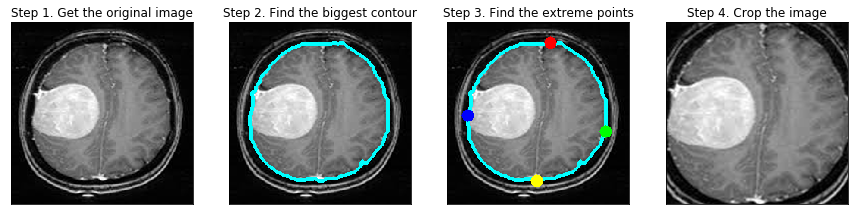

In [2]:
IMG_SIZE=(240,240)
img = cv2.imread('F:\Major Project 2019\BrainKag\yes\Y1.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [3]:
def crop_brain_contour(image, plot=False):
   
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In [4]:
def load_data(dir_list, image_size):
 # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            # load the image
            image = cv2.imread(os.path.join(directory,filename))
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [9]:

augmented_path = r"F:\Major Project 2019\BrainKag\\"

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no],(IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)


In [10]:
def plot_sample_images(X, y, n=20):
    
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 5
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

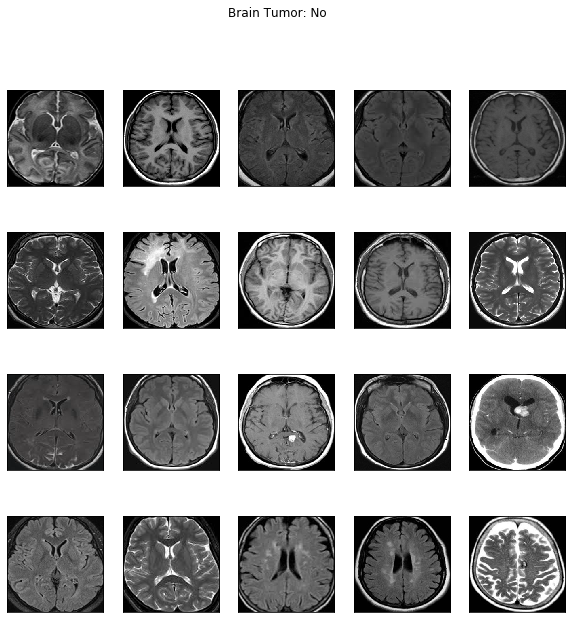

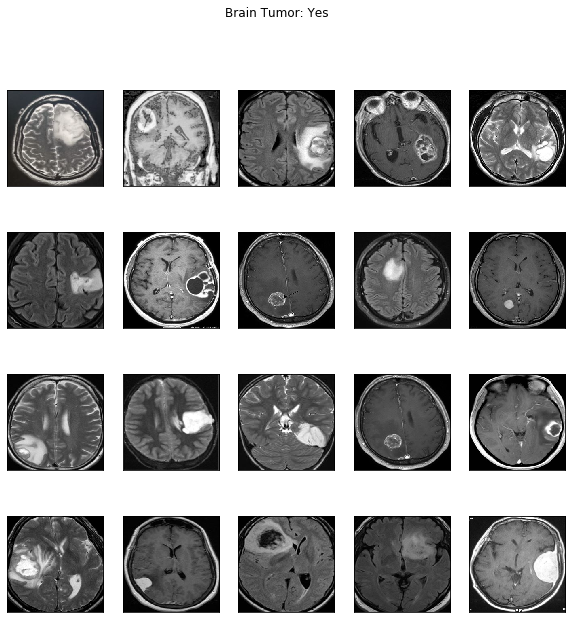

In [11]:
plot_sample_images(X, y)

In [12]:
def split_data(X, y, test_size=0.2):
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [13]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [14]:

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 177
number of development examples = 38
number of test examples = 38
X_train shape: (177, 240, 240, 3)
Y_train shape: (177, 1)
X_val (dev) shape: (38, 240, 240, 3)
Y_val (dev) shape: (38, 1)
X_test shape: (38, 240, 240, 3)
Y_test shape: (38, 1)


In [15]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [16]:
def build_model(input_shape):
    
    
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation="sigmoid", name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [17]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [35]:
model = build_model(IMG_SHAPE)

In [36]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

In [42]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [58]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{(time.time())}'
tensorboard = TensorBoard(log_dir=f'F:\Major Project 2019\logs\{log_file_name}')
print(tensorboard)

In [59]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("F:/Major Project 2019/BrainKag/models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

In [60]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])


Train on 177 samples, validate on 38 samples
Epoch 1/3
177/177 [==============================] - 100s 563ms/sample - loss: 0.9002 - acc: 0.6723 - val_loss: 0.6064 - val_acc: 0.6842
Epoch 2/3
177/177 [==============================] - 54s 303ms/sample - loss: 0.5537 - acc: 0.7006 - val_loss: 0.6019 - val_acc: 0.6842
Epoch 3/3
177/177 [==============================] - 51s 287ms/sample - loss: 0.4011 - acc: 0.8079 - val_loss: 0.6578 - val_acc: 0.6842


In [120]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

Train on 177 samples, validate on 38 samples
Epoch 1/3
177/177 [==============================] - 181s 1s/sample - loss: 0.3508 - acc: 0.8870 - val_loss: 0.6489 - val_acc: 0.7368
Epoch 2/3
177/177 [==============================] - 167s 942ms/sample - loss: 0.3199 - acc: 0.8870 - val_loss: 0.6373 - val_acc: 0.7895
Epoch 3/3
177/177 [==============================] - 93s 524ms/sample - loss: 0.2796 - acc: 0.9153 - val_loss: 0.6216 - val_acc: 0.7632


In [121]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

Train on 177 samples, validate on 38 samples
Epoch 1/3
177/177 [==============================] - 107s 603ms/sample - loss: 0.2501 - acc: 0.9266 - val_loss: 0.6023 - val_acc: 0.7895
Epoch 2/3
177/177 [==============================] - 92s 518ms/sample - loss: 0.2314 - acc: 0.9322 - val_loss: 0.6019 - val_acc: 0.7368
Epoch 3/3
177/177 [==============================] - 82s 461ms/sample - loss: 0.2217 - acc: 0.9322 - val_loss: 0.6328 - val_acc: 0.6842


In [122]:

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])


Train on 177 samples, validate on 38 samples
Epoch 1/3
177/177 [==============================] - 104s 585ms/sample - loss: 0.2133 - acc: 0.9266 - val_loss: 0.5944 - val_acc: 0.7368
Epoch 2/3
177/177 [==============================] - 115s 649ms/sample - loss: 0.2256 - acc: 0.9209 - val_loss: 0.5935 - val_acc: 0.7368
Epoch 3/3
177/177 [==============================] - 112s 633ms/sample - loss: 0.1923 - acc: 0.9322 - val_loss: 0.6123 - val_acc: 0.7105


In [123]:

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])


Train on 177 samples, validate on 38 samples
Epoch 1/5
177/177 [==============================] - 92s 518ms/sample - loss: 0.1690 - acc: 0.9605 - val_loss: 0.6099 - val_acc: 0.7105
Epoch 2/5
177/177 [==============================] - 134s 758ms/sample - loss: 0.1868 - acc: 0.9322 - val_loss: 0.5707 - val_acc: 0.7895
Epoch 3/5
177/177 [==============================] - 56s 315ms/sample - loss: 0.1566 - acc: 0.9661 - val_loss: 0.6199 - val_acc: 0.7105
Epoch 4/5
177/177 [==============================] - 85s 478ms/sample - loss: 0.1371 - acc: 0.9774 - val_loss: 0.5888 - val_acc: 0.7368
Epoch 5/5
177/177 [==============================] - 70s 393ms/sample - loss: 0.1180 - acc: 0.9774 - val_loss: 0.5900 - val_acc: 0.7368


In [124]:

history = model.history.history
print(history)

{'loss': [0.1690018744455219, 0.18675769608741427, 0.15664166207872543, 0.13710190427336988, 0.11802482727052128], 'acc': [0.96045196, 0.9322034, 0.9661017, 0.97740114, 0.97740114], 'val_loss': [0.60985750587363, 0.570677616094288, 0.6199459496297335, 0.5887684790711654, 0.5899940195836519], 'val_acc': [0.7105263, 0.7894737, 0.7105263, 0.7368421, 0.7368421]}


In [62]:
for key in history.keys():
    print(key)

loss
acc
val_loss
val_acc


In [125]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

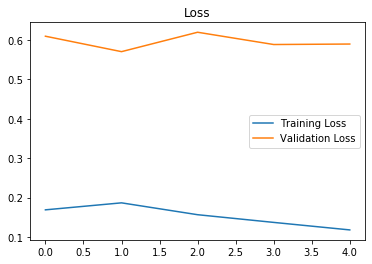

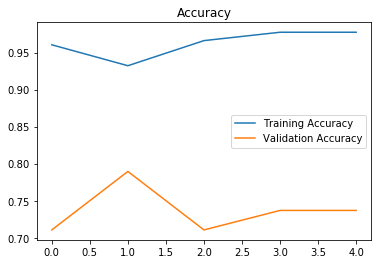

In [126]:
plot_metrics(history)


In [128]:

best_model = load_model(filepath='F:\Major Project 2019\BrainKag\models\cnn-parameters-improvement-02-0.79.model')
best_model.metrics_names

['loss', 'acc']

In [68]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

38/38 [==============================] - 2s 57ms/sample - loss: 0.6928 - acc: 0.6053


In [129]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.6928023664574874
Test Accuracy = 0.6052631735801697


In [130]:
y_test_prob = best_model.predict(X_test)
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.6666666666666666


In [131]:
y_val_prob = best_model.predict(X_val)

In [132]:

f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.8571428571428571


In [133]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")

In [134]:
data_percentage(y)


Number of examples: 253
Percentage of positive examples: 61.26482213438735%, number of pos examples: 155
Percentage of negative examples: 38.73517786561265%, number of neg examples: 98


In [135]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 177
Percentage of positive examples: 59.887005649717516%, number of pos examples: 106
Percentage of negative examples: 40.112994350282484%, number of neg examples: 71
Validation Data:
Number of examples: 38
Percentage of positive examples: 68.42105263157895%, number of pos examples: 26
Percentage of negative examples: 31.57894736842105%, number of neg examples: 12
Testing Data:
Number of examples: 38
Percentage of positive examples: 60.526315789473685%, number of pos examples: 23
Percentage of negative examples: 39.473684210526315%, number of neg examples: 15


In [136]:
# serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [137]:
from keras.models import model_from_json
# from keras.utils import CustomObjectScope
# from keras.initializers import glorot_uniform


class BrainDLModel(object):

    LIST = ["Tumor","Non-Tumor"]

    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = tf.keras.models.model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        self.loaded_model._make_predict_function()

    def predict_tumor(self, img):
        self.preds = self.loaded_model.predict(img)
        print(self.preds)
        print(type(self.preds))
        print(self.preds[0][0])
        if(int(self.preds[0][0])==1):
            return BrainDLModel.LIST[0]
        else:
            return BrainDLModel.LIST[1]
        
       # return BrainDLModel.LIST[np.argmax(self.preds)]


In [138]:
Pred_Model = BrainDLModel("model.json",'F:\Major Project 2019\BrainKag\models\cnn-parameters-improvement-01-0.68.model')

In [109]:
!pip install pydicom

In [143]:
#from google.colab import files
import pydicom as dicom
import os
import cv2


In [144]:
 # optional
upload = files.upload()

k=list(upload.keys())
filen=k[0]
if(filen[-3:]=="dcm"):
  # make it True if you want in PNG format
  PNG = False
  
ds = dicom.dcmread(filen)
pixel_array_numpy = ds.pixel_array
img = pixel_array_numpy
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
img=img.reshape(-1,240,240,3)
Pred_Model.predict_tumor(img)

NameError: name 'files' is not defined

In [146]:
img = cv2.imread(r"F:\Major Project 2019\BrainKag\no\N21.jpg")
#ds = dicom.dcmread("F:\Major Project 2019\BrainKag\yes\Y21.jpg")
#img= ds.pixel_array
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
img=img.reshape(-1,240,240,3)
print(Pred_Model.predict_tumor(img))

[[1.]]
<class 'numpy.ndarray'>
1.0
Tumor
